# Neuroprosthetics Exercise 5 - Alexander Koenig

## Subtask 1 - Create a Multi Compartment Model

In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt

rcParams['font.family'] = "Arial"
rcParams['xtick.labelsize'] = 11
rcParams['ytick.labelsize'] = 11
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 12
rcParams['axes.grid'] = True

In [2]:
# define rate equations
alpha_m = lambda V: (2.5 - 0.1*V) / (np.exp(2.5 - 0.1*V) - 1)
alpha_n = lambda V: (0.1 - 0.01*V) / (np.exp(1 - 0.1*V) - 1)
alpha_h = lambda V: 0.07 * np.exp(- V/20)
beta_m = lambda V: 4 * np.exp(- V/18)
beta_n = lambda V: 0.125 * np.exp(- V/80)
beta_h = lambda V: 1 / (np.exp(3 - 0.1*V) + 1)

# temperature correction
k = lambda T: 3 ** (0.1*(T-6.3))

# time constant
tau_x = lambda alpha, beta, k: 1 / ((alpha + beta) * k)

# steady state value
x_inf = lambda alpha, beta: alpha / (alpha + beta)

# ionic currents
i_na = lambda m, h, V: 120 * m**3 * h * (V - 115)
i_k = lambda n, V: 36 * n**4 * (V + 12)
i_l = lambda V: 0.3 * (V - 10.6)

# gating odes in A, B form for Exponential Euler
A_m = lambda V, T: - 1 / tau_x(alpha_m(V), beta_m(V), k(T))
A_n = lambda V, T: - 1 / tau_x(alpha_n(V), beta_n(V), k(T))
A_h = lambda V, T: - 1 / tau_x(alpha_h(V), beta_h(V), k(T))
B_m = lambda V, T: x_inf(alpha_m(V), beta_m(V)) / tau_x(alpha_m(V), beta_m(V), k(T))
B_n = lambda V, T: x_inf(alpha_n(V), beta_n(V)) / tau_x(alpha_n(V), beta_n(V), k(T))
B_h = lambda V, T: x_inf(alpha_h(V), beta_h(V)) / tau_x(alpha_h(V), beta_h(V), k(T))

In [3]:
def exponential_euler_step(A, B, prev_value, step_size):
    """One time step of Exponential Euler Method"""
    
    next_value = prev_value*np.exp(A*step_size) + B/A*(np.exp(A*step_size) - 1)
    
    return next_value

def explicit_euler_step(ode_rhs, prev_value, step_size):
    """One time step of Explicit Euler Method"""
    
    next_value = prev_value + ode_rhs * step_size
    
    return next_value

def get_i_stim_1(time, compartments):
    """Definition of stimulation current as given in exercise"""
    i_stim = np.zeros((compartments, 1))
    
    if time >= 0 and time < 5:
        i_stim[0] = 10
    
    return i_stim

def get_i_stim_2(time, compartments):
    """Definition of stimulation current as given in exercise"""
    i_stim = np.zeros((compartments, 1))
    
    if time >= 0 and time < 5:
        i_stim[19] = 10
        i_stim[79] = 10
    
    return i_stim

def connection_matrix(compartments): 
    C = np.eye(compartments)*-2
    C[0,0] = -1
    C[compartments-1, compartments-1] = -1
    for i in range (0, compartments):
        for j in range (0, compartments):
            if i == j + 1 or i == j - 1:
                C[i,j] = 1
    return C

def hh_current(V, T, prev_gating_vars, step_size):
    """Solves gating odes for one time step and returns ion currents and gating variables in next time step for all cells"""
    
    m = exponential_euler_step(A_m(V, T), B_m(V, T), prev_gating_vars[:,0].reshape(-1,1), step_size)
    n = exponential_euler_step(A_n(V, T), B_n(V, T), prev_gating_vars[:,1].reshape(-1,1), step_size)
    h = exponential_euler_step(A_h(V, T), B_h(V, T), prev_gating_vars[:,2].reshape(-1,1), step_size)
    
    i_ions = np.concatenate((i_na(m, h, V), i_k(n, V), i_l(V)), axis=1)
    gating_vars = np.concatenate((m, n, h), axis=1)
    
    return i_ions, gating_vars

def hh_model(T, start_time, end_time, step_size, compartments, get_i_stim, c_m, r_a):
    """
    T:              temperature
    start_time:     starting time of simulation
    end_time:       ending time of simulation
    step_size:      step size
    compartments:   number of compartments
    get_i_stim:     function that returns stimulation current
    c_m:            membrane capacitance
    r_a:            axonal resistance
    """
    
    V_rest = 0
    V_membrane = np.full((1, compartments, 1), V_rest)
    times = np.arange(start_time, end_time, step_size)
    C = connection_matrix(compartments)
    
    # gating variables at resting potential for all cells
    m_inf = x_inf(alpha_m(V_membrane), beta_m(V_membrane))
    n_inf = x_inf(alpha_n(V_membrane), beta_n(V_membrane))
    h_inf = x_inf(alpha_h(V_membrane), beta_h(V_membrane))
    gating_vars = np.concatenate((m_inf, n_inf, h_inf), axis=2)
    
    # currents at resting potential for all cells
    i_ions = np.concatenate((i_na(m_inf, h_inf, V_membrane), i_k(n_inf, V_membrane), i_l(V_membrane)), axis=2)

    for time in times[1:]:
        
        # exponential euler step and append results
        next_i_ions, next_gating_vars = hh_current(V_membrane[-1], T, gating_vars[-1], step_size)
        i_ions = np.concatenate((i_ions, [next_i_ions]))
        gating_vars = np.concatenate((gating_vars, [next_gating_vars]))
        
        # hodkin-huxley current for current time step
        i_hh = np.sum(i_ions[-1], axis=1).reshape((-1,1))
        
        # solve cable equation and append results
        A = np.eye(compartments) - step_size*C/(c_m*r_a)
        b = V_membrane[-1] + (step_size/c_m)*(get_i_stim(time, compartments) - i_hh)
        next_V_membrane = np.linalg.solve(A, b)
        V_membrane = np.concatenate((V_membrane, [next_V_membrane]))
        
    return V_membrane, gating_vars, i_ions, times

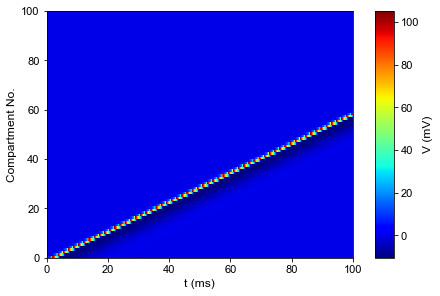

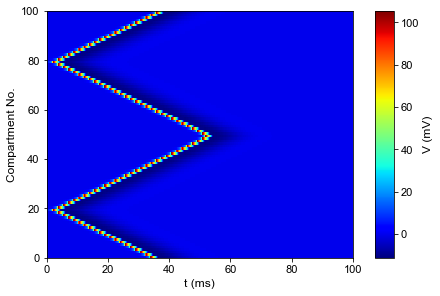

In [4]:
# model parameters 
resistance = lambda rho, l, r: rho * l / (np.pi * r**2)
rho_axon = 0.1
l_comp = 0.1e-4
r_axon = 2e-4
resistance_axon = resistance(rho_axon, l_comp, r_axon)

currents = [(get_i_stim_1, "case1"), (get_i_stim_2, "case2")]
step_size = 0.025
start_time = 0
end_time = 100
temperature = 6.3
capacitance = 1
no_compartments = 101
compartments = np.arange(0, no_compartments, 1)

for current in currents:
    
    # run simulation 
    V_membrane, gating_vars, i_ions, times = hh_model(temperature, start_time, end_time, step_size, no_compartments, current[0], capacitance, resistance_axon)
    
    # prepare plot 
    y, x = np.mgrid[slice(0, no_compartments, 1), slice(start_time, end_time, step_size)]
    cmap = plt.get_cmap('jet')
    
    # plot results
    fig = plt.figure(constrained_layout=True)
    V_membrane = np.swapaxes(V_membrane, 0, 2)
    plot = plt.pcolormesh(x, y, V_membrane[-1], cmap=cmap)
    plt.xlabel("t (ms)")
    plt.ylabel("Compartment No.")
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    cbar = fig.colorbar(plot)
    cbar.set_label("V (mV)")
    plt.show()
    fig.savefig(f"../figures/potential_{current[1]}.png", dpi=500)

Starting simulation with axonal resistance 3.98
Starting simulation with axonal resistance 7.96
Starting simulation with axonal resistance 10.35
Starting simulation with axonal resistance 15.92


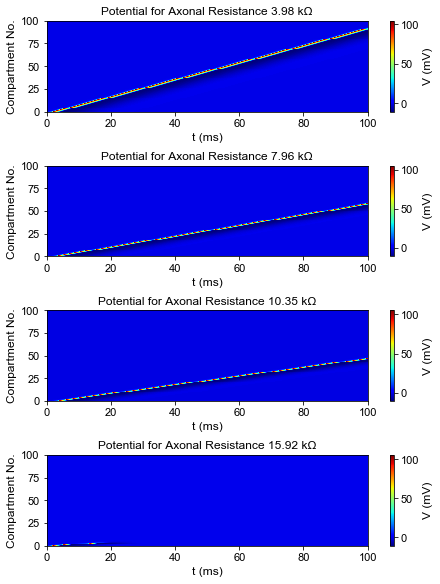

In [5]:
# investigate effect of axonal resistances

resistances = [0.5*resistance_axon, resistance_axon, 1.3*resistance_axon, 2*resistance_axon]

fig, axs = plt.subplots(4, figsize=(6,8), constrained_layout=True)
i = 0

for r in resistances: 
    print(f"Starting simulation with axonal resistance {round(r, 2)}")
    V_membrane, gating_vars, i_ions, times = hh_model(temperature, start_time, end_time, step_size, no_compartments, get_i_stim_1, capacitance, r)
    V_membrane = np.swapaxes(V_membrane, 0, 2)
    plot = axs[i].pcolormesh(x, y, V_membrane[-1], cmap=cmap)
    axs[i].set_title(f"Potential for Axonal Resistance {round(r, 2)} k\u03A9")
    axs[i].set(xlabel="t (ms)", ylabel="Compartment No.")
    axs[i].set_xlim(0, 100)
    axs[i].set_ylim(0, 100)
    axs[i].set_axisbelow(True)
    cbar = fig.colorbar(plot, ax=axs[i])
    cbar.set_label("V (mV)")
    i += 1
    
plt.show()
fig.savefig(f"../figures/potential_experiments_resistance.png", dpi=500)

Starting simulation with capacitance 0.5
Starting simulation with capacitance 1
Starting simulation with capacitance 1.3
Starting simulation with capacitance 2


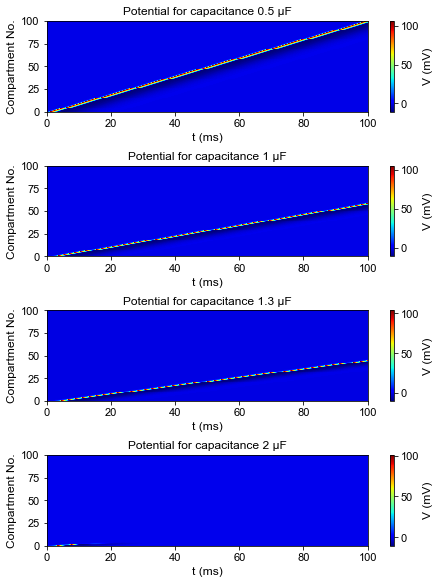

In [6]:
# investigate effect of capacities

capacitances = [0.5*capacitance, capacitance, 1.3*capacitance, 2*capacitance]

fig, axs = plt.subplots(4, figsize=(6,8), constrained_layout=True)
i = 0

for c in capacitances:
    print(f"Starting simulation with capacitance {c}")
    V_membrane, gating_vars, i_ions, times = hh_model(temperature, start_time, end_time, step_size, no_compartments, get_i_stim_1, c, resistance_axon)
    V_membrane = np.swapaxes(V_membrane, 0, 2)
    plot = axs[i].pcolormesh(x, y, V_membrane[-1], cmap=cmap)
    axs[i].set_title(f"Potential for capacitance {c} \u03BCF")
    axs[i].set(xlabel="t (ms)", ylabel="Compartment No.")
    axs[i].set_xlim(0, 100)
    axs[i].set_ylim(0, 100)
    axs[i].set_axisbelow(True)
    cbar = fig.colorbar(plot, ax=axs[i])
    cbar.set_label("V (mV)")
    i += 1
    
plt.show()
fig.savefig(f"../figures/potential_experiments_capacitance.png", dpi=500)

Starting simulation with temperature 3.15
Starting simulation with temperature 6.3
Starting simulation with temperature 8.19
Starting simulation with temperature 12.6


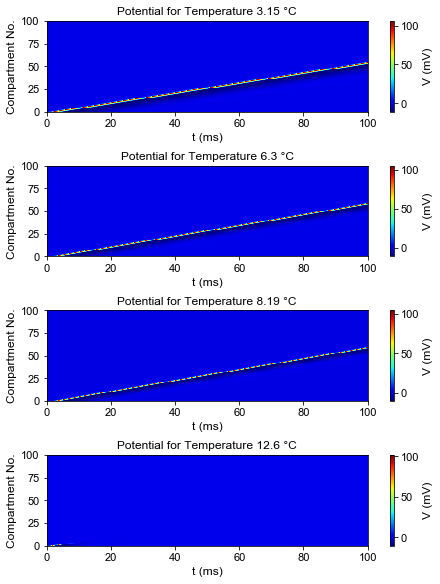

In [7]:
# investigate effect of temperature

temperatures = [0.5*temperature, temperature, 1.3*temperature, 2*temperature]

fig, axs = plt.subplots(4, figsize=(6,8), constrained_layout=True)
i = 0

for t in temperatures: 
    print(f"Starting simulation with temperature {t}")
    V_membrane, gating_vars, i_ions, times = hh_model(t, start_time, end_time, step_size, no_compartments, get_i_stim_1, capacitance, resistance_axon)
    V_membrane = np.swapaxes(V_membrane, 0, 2)
    plot = axs[i].pcolormesh(x, y, V_membrane[-1], cmap=cmap)
    axs[i].set_title(f"Potential for Temperature {t} \u00b0C")
    axs[i].set(xlabel="t (ms)", ylabel="Compartment No.")
    axs[i].set_xlim(0, 100)
    axs[i].set_ylim(0, 100)
    axs[i].set_axisbelow(True)
    cbar = fig.colorbar(plot, ax=axs[i])
    cbar.set_label("V (mV)")
    i += 1
    
plt.show()
fig.savefig(f"../figures/potential_experiments_temperature.png", dpi=500)

# interpretation: in this model temperature does not have a significant effect on signal transmission speed